# Run Experiments

You can use the Azure Machine Learning SDK to run code experiments that log metrics and generate outputs. This is at the core of most machine learning operations in Azure Machine Learning.

## Connect to your workspace

All experiments and associated resources are managed within your Azure Machine Learning workspace. In most cases, you should store the workspace configuration in a JSON configuration file. This makes it easier to reconnect without needing to remember details like your Azure subscription ID. You can download the JSON configuration file from the blade for your workspace in the Azure portal, but if you're using a Compute Instance within your wokspace, the configuration file has already been downloaded to the root folder.

The code below uses the configuration file to connect to your workspace.

> **Note**: If you haven't already established an authenticated session with your Azure subscription, you'll be prompted to authenticate by clicking a link, entering an authentication code, and signing into Azure.

In [1]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.22.0 to work with dp100_ml


## Run an experiment

One of the most fundamentals tasks that data scientists need to perform is to create and run experiments that process and analyze data. In this exercise, you'll learn how to use an Azure ML *experiment* to run Python code and record values extracted from data. In this case, you'll use a simple dataset that contains details of patients that have been tested for diabetes. You'll run an experiment to explore the data, extracting statistics, visualizations, and data samples. Most of the code you'll use is fairly generic Python, such as you might run in any data exploration process. However, with the addition of a few lines, the code uses an Azure ML *experiment* to log details of the run.

Starting experiment: mslearn-diabetes
Analyzing 10000 rows of data


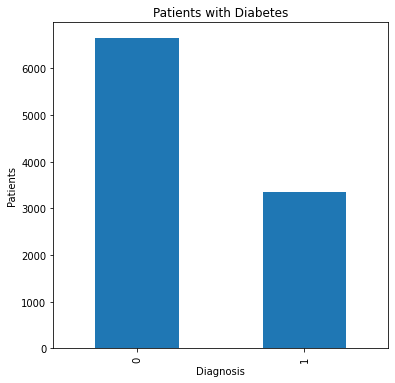

In [2]:
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Create an Azure ML experiment in your workspace
experiment = Experiment(workspace=ws, name="mslearn-diabetes")

# Start logging data from the experiment, obtaining a reference to the experiment run
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

# load the data from a local file
data = pd.read_csv('data/diabetes.csv')

# Count the rows and log the result
row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# Plot and log the count of diabetic vs non-diabetic patients
diabetic_counts = data['Diabetic'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
diabetic_counts.plot.bar(ax = ax) 
ax.set_title('Patients with Diabetes') 
ax.set_xlabel('Diagnosis') 
ax.set_ylabel('Patients')
plt.show()
run.log_image(name='label distribution', plot=fig)

# log distinct pregnancy counts
pregnancies = data.Pregnancies.unique()
run.log_list('pregnancy categories', pregnancies)

# Log summary statistics for numeric columns
med_columns = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']
summary_stats = data[med_columns].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for index in range(len(keys)):
        run.log_row(col, stat=keys[index], value = values[index])
        
# Save a sample of the data and upload it to the experiment output
data.sample(100).to_csv('sample.csv', index=False, header=True)
run.upload_file(name='outputs/sample.csv', path_or_stream='./sample.csv')

# Complete the run
run.complete()

## View run details

In Jupyter Notebooks, you can use the **RunDetails** widget to see a visualization of the run details.

In [3]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### View more details in Azure Machine Learning studio

Note that the **RunDetails** widget includes a link to **view run details** in Azure Machine Learning studio. Click this to open a new browser tab with the run details (you can also just open [Azure Machine Learning studio](https://ml.azure.com) and find the run on the **Experiments** page). When viewing the run in Azure Machine Learning studio, note the following:

- The **Details** tab contains the general properties of the experiment run.
- The **Metrics** tab enables you to select logged metrics and view them as tables or charts.
- The **Images** tab enables you to select and view any images or plots that were logged in the experiment (in this case, the *Label Distribution* plot)
- The **Child Runs** tab lists any child runs (in this experiment there are none).
- The **Outputs + Logs** tab shows the output or log files generated by the experiment.
- The **Snapshot** tab contains all files in the folder where the experiment code was run (in this case, everything in the same folder as this notebook).
- The **Explanations** tab is used to show model explanations generated by the experiment (in this case, there are none).
- The **Fairness** tab is used to visualize predictive performance disparities that help you evaluate the fairness of machine learning models (in this case, there are none).

### Retrieve experiment details using the SDK

The **run** variable in the code you ran previously is an instance of a **Run** object, which is a reference to an individual run of an experiment in Azure Machine Learning. You can use this reference to get information about the run and its outputs:

In [4]:
import json

# Get logged metrics
print("Metrics:")
metrics = run.get_metrics()
for metric_name in metrics:
    print(metric_name, ":", metrics[metric_name])

# Get output files
print("\nFiles:")
files = run.get_file_names()
for file in files:
    print(file)

Metrics:
observations : 10000
label distribution : aml://artifactId/ExperimentRun/dcid.9ad9d3ff-483c-4b26-b327-a7aede459316/label distribution_1615921547.png
pregnancy categories : [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
PlasmaGlucose : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.920909360565563, 44.0, 84.0, 105.0, 129.0, 192.0]}
DiastolicBloodPressure : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 71.2075, 16.801478289640706, 24.0, 58.0, 72.0, 85.0, 117.0]}
TricepsThickness : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228332, 7.0, 15.0, 31.0, 41.0, 92.0]}
SerumInsulin : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 139.2436, 133.77791937465278, 14.0, 39.0, 85.0, 197.0, 796.0]}
BMI : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [1000

You can download the files produced by the experiment, either individually by using the **download_file** method, or by using the **download_files** method to retrieve multiple files. The following code downloads all of the files in the run's **output** folder:

In [5]:
import os

download_folder = 'downloaded-files'

# Download files in the "outputs" folder
run.download_files(prefix='outputs', output_directory=download_folder)

# Verify the files have been downloaded
for root, directories, filenames in os.walk(download_folder): 
    for filename in filenames:  
        print (os.path.join(root,filename))

downloaded-files/outputs/sample.csv


If you need to troubleshoot the experiment run, you can use the **get_details** method to retrieve basic details about the run, or you can use the **get_details_with_logs** method to retrieve the run details as well as the contents of log files generated during the run:

In [6]:
run.get_details_with_logs()

{'runId': '9ad9d3ff-483c-4b26-b327-a7aede459316',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-03-16T19:05:38.323567Z',
 'endTimeUtc': '2021-03-16T19:05:53.509937Z',
 'properties': {'azureml.git.repository_uri': 'https://github.com/MicrosoftLearning/mslearn-dp100',
  'mlflow.source.git.repoURL': 'https://github.com/MicrosoftLearning/mslearn-dp100',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '14aaf3f5eabb286b5d3eb73ae8bafa95d78ddcfa',
  'mlflow.source.git.commit': '14aaf3f5eabb286b5d3eb73ae8bafa95d78ddcfa',
  'azureml.git.dirty': 'True',
  'ContentSnapshotId': '1f37c181-19ce-450f-9bed-89998bd68554'},
 'inputDatasets': [],
 'outputDatasets': [],
 'logFiles': {},
 'submittedBy': 'ChangYuan Liu'}

Note that the details include information about the compute target on which the experiment was run, the date and time when it started and ended. Additionally, because the notebook containing the experiment code (this one) is in a cloned Git repository, details about the repo, branch, and status are recorded in the run history.

In this case, note that the **logFiles** entry in the details indicates that no log files were generated. That's typical for an inline experiment like the one you ran, but things get more interesting when you run a script as an experiment; which is what we'll look at next.

## Run an experiment script

In the previous example, you ran an experiment inline in this notebook. A more flexible solution is to create a separate script for the experiment, and store it in a folder along with any other files it needs, and then use Azure ML to run the experiment based on the script in the folder.

First, let's create a folder for the experiment files, and copy the data into it:

In [7]:
import os, shutil

# Create a folder for the experiment files
folder_name = 'diabetes-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

# Copy the data file into the experiment folder
shutil.copy('data/diabetes.csv', os.path.join(folder_name, "diabetes.csv"))

'diabetes-experiment-files/diabetes.csv'

Now we'll create a Python script containing the code for our experiment, and save it in the experiment folder.

> **Note**: running the following cell just *creates* the script file - it doesn't run it!

In [8]:
%%writefile $folder_name/diabetes_experiment.py
from azureml.core import Run
import pandas as pd
import os

# Get the experiment run context
run = Run.get_context()

# load the diabetes dataset
data = pd.read_csv('diabetes.csv')

# Count the rows and log the result
row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# Count and log the label counts
diabetic_counts = data['Diabetic'].value_counts()
print(diabetic_counts)
for k, v in diabetic_counts.items():
    run.log('Label:' + str(k), v)
      
# Save a sample of the data in the outputs folder (which gets uploaded automatically)
os.makedirs('outputs', exist_ok=True)
data.sample(100).to_csv("outputs/sample.csv", index=False, header=True)

# Complete the run
run.complete()

Writing diabetes-experiment-files/diabetes_experiment.py


This code is a simplified version of the inline code used before. However, note the following:
- It uses the `Run.get_context()` method to retrieve the experiment run context when the script is run.
- It loads the diabetes data from the folder where the script is located.
- It creates a folder named **outputs** and writes the sample file to it - this folder is automatically uploaded to the experiment run

Now you're almost ready to run the experiment. To run the script, you must create a **ScriptRunConfig** that identifies the Python script file to be run in the experiment, and then run an experiment based on it.

> **Note**: The ScriptRunConfig also determines the compute target and Python environment. If you don't specify these, a default environment is created automatically on the local compute where the code is being run (in this case, where this notebook is being run).

The following cell configures and submits the script-based experiment.

In [9]:
import os
import sys
from azureml.core import Experiment, ScriptRunConfig
from azureml.widgets import RunDetails


# Create a script config
script_config = ScriptRunConfig(source_directory=experiment_folder, 
                      script='diabetes_experiment.py') 

# submit the experiment
experiment = Experiment(workspace=ws, name='mslearn-diabetes')
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-diabetes_1615921570_15df8749',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2021-03-16T19:07:51.885453Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'c9468608-d1e4-460c-aa5d-cd8d2c91b42c',
  'azureml.git.repository_uri': 'https://github.com/MicrosoftLearning/mslearn-dp100',
  'mlflow.source.git.repoURL': 'https://github.com/MicrosoftLearning/mslearn-dp100',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '14aaf3f5eabb286b5d3eb73ae8bafa95d78ddcfa',
  'mlflow.source.git.commit': '14aaf3f5eabb286b5d3eb73ae8bafa95d78ddcfa',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData'

As before, you can use the widget or the link to the experiment in [Azure Machine Learning studio](https://ml.azure.com) to view the outputs generated by the experiment, and you can also write code to retrieve the metrics and files it generated:

In [10]:
# Get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

observations 10000
Label:0 6656
Label:1 3344


azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/18419_azureml.log
outputs/sample.csv


Note that this time, the run generated some log files. You can view these in the widget, or you can use the **get_details_with_logs** method like we did before, only this time the output will include the log data.

In [11]:
run.get_details_with_logs()

{'runId': 'mslearn-diabetes_1615921570_15df8749',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2021-03-16T19:07:51.885453Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'c9468608-d1e4-460c-aa5d-cd8d2c91b42c',
  'azureml.git.repository_uri': 'https://github.com/MicrosoftLearning/mslearn-dp100',
  'mlflow.source.git.repoURL': 'https://github.com/MicrosoftLearning/mslearn-dp100',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '14aaf3f5eabb286b5d3eb73ae8bafa95d78ddcfa',
  'mlflow.source.git.commit': '14aaf3f5eabb286b5d3eb73ae8bafa95d78ddcfa',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData'

Although you can view the log details in the output above, it's usually easier to download the log files and view them in a text editor.

In [12]:
import os

log_folder = 'downloaded-logs'

# Download all files
run.get_all_logs(destination=log_folder)

# Verify the files have been downloaded
for root, directories, filenames in os.walk(log_folder): 
    for filename in filenames:  
        print (os.path.join(root,filename))

downloaded-logs/azureml-logs/60_control_log.txt
downloaded-logs/azureml-logs/70_driver_log.txt
downloaded-logs/logs/azureml/18419_azureml.log


## View experiment run history

Now that you've run the same experiment multiple times, you can view the history in [Azure Machine Learning studio](https://ml.azure.com) and explore each logged run. Or you can retrieve an experiment by name from the workspace and iterate through its runs using the SDK:

In [13]:
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['mslearn-diabetes']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))

Run ID: mslearn-diabetes_1615921570_15df8749
- observations 10000
- Label:0 6656
- Label:1 3344
Run ID: 9ad9d3ff-483c-4b26-b327-a7aede459316
- observations 10000
- label distribution aml://artifactId/ExperimentRun/dcid.9ad9d3ff-483c-4b26-b327-a7aede459316/label distribution_1615921547.png
- pregnancy categories [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
- PlasmaGlucose {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.920909360565563, 44.0, 84.0, 105.0, 129.0, 192.0]}
- DiastolicBloodPressure {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 71.2075, 16.801478289640706, 24.0, 58.0, 72.0, 85.0, 117.0]}
- TricepsThickness {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228332, 7.0, 15.0, 31.0, 41.0, 92.0]}
- SerumInsulin {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 139.2436, 133.7779193

## Use MLflow

MLflow is an open source platform for managing machine learning processes. It's commonly (but not exclusively) used in Databricks environments to coordinate experiments and track metrics. In Azure Machine Learning experiments, you can use MLflow to track metrics as an alternative to the native log functionality.

To take advantage of this capability, you'll need the **mlflow** and **azureml-mlflow** packages, so let's ensure they are installed.

In [14]:
!pip show mlflow azureml-mlflow

Name: mlflow
Version: 1.13.1
Summary: MLflow: A Platform for ML Development and Productionization
Home-page: https://mlflow.org/
Author: Databricks
Author-email: None
License: Apache License 2.0
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: entrypoints, querystring-parser, six, sqlparse, prometheus-flask-exporter, alembic, python-dateutil, cloudpickle, gitpython, sqlalchemy, pyyaml, databricks-cli, click, protobuf, pandas, docker, requests, numpy, azure-storage-blob, Flask, gunicorn
Required-by: azureml-mlflow
---
Name: azureml-mlflow
Version: 1.22.0
Summary: UNKNOWN
Home-page: https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py
Author: Microsoft Corp
Author-email: None
License: Proprietary https://aka.ms/azureml-preview-sdk-license 
Location: /anaconda/envs/azureml_py36/lib/python3.6/site-packages
Requires: mlflow, jsonpickle, azureml-core
Required-by: 


### Use MLflow with an inline experiment

To use MLflow to track metrics for an inline experiment, you must set the MLflow *tracking URI* to the workspace where the experiment is being run. This enables you to use **mlflow** tracking methods to log data to the experiment run.

In [15]:
from azureml.core import Experiment
import pandas as pd
import mlflow

# Set the MLflow tracking URI to the workspace
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

# Create an Azure ML experiment in your workspace
experiment = Experiment(workspace=ws, name='mslearn-diabetes-mlflow')
mlflow.set_experiment(experiment.name)

# start the MLflow experiment
with mlflow.start_run():
    
    print("Starting experiment:", experiment.name)
    
    # Load data
    data = pd.read_csv('data/diabetes.csv')

    # Count the rows and log the result
    row_count = (len(data))
    mlflow.log_metric('observations', row_count)
    print("Run complete")

Starting experiment: mslearn-diabetes-mlflow
Run complete


Now let's look at the metrics logged during the run

In [17]:
# Get the latest run of the experiment
run = list(experiment.get_runs())[0]

# Get logged metrics
print("\nMetrics:")
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
    
# Get a link to the experiment in Azure ML studio   
experiment_url = experiment.get_portal_url()
print('See details at', experiment_url)


Metrics:
observations 10000.0
See details at https://ml.azure.com/experiments/mslearn-diabetes-mlflow?wsid=/subscriptions/8e2eae19-fb68-43d0-a429-b4d1a6bcf2d1/resourcegroups/dp100/workspaces/dp100_ml


After running the code above, you can use the link that is displayed to view the experiment in Azure Machine Learning studio. Then select the latest run of the experiment and view its **Metrics** tab to see the logged metric.

### Use MLflow in an experiment script

You can also use MLflow to track metrics in an experiment script.

Run the following two cells to create a folder and a script for an experiment that uses MLflow.

In [18]:
import os, shutil

# Create a folder for the experiment files
folder_name = 'mlflow-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

# Copy the data file into the experiment folder
shutil.copy('data/diabetes.csv', os.path.join(folder_name, "diabetes.csv"))

'mlflow-experiment-files/diabetes.csv'

In [19]:
%%writefile $folder_name/mlflow_diabetes.py
from azureml.core import Run
import pandas as pd
import mlflow


# start the MLflow experiment
with mlflow.start_run():
       
    # Load data
    data = pd.read_csv('diabetes.csv')

    # Count the rows and log the result
    row_count = (len(data))
    print('observations:', row_count)
    mlflow.log_metric('observations', row_count)

Writing mlflow-experiment-files/mlflow_diabetes.py


When you use MLflow tracking in an Azure ML experiment script, the MLflow tracking URI is set automatically when you start the experiment run. However, the environment in which the script is to be run must include the required **mlflow** packages.

In [ ]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails


# Create a Python environment for the experiment
mlflow_env = Environment("mlflow-env")

# Ensure the required packages are installed
packages = CondaDependencies.create(conda_packages=['pandas','pip'],
                                    pip_packages=['mlflow','azureml-mlflow'])
mlflow_env.python.conda_dependencies = packages

# Create a script config
script_mlflow = ScriptRunConfig(source_directory=experiment_folder,
                                script='mlflow_diabetes.py',
                                environment=mlflow_env) 

# submit the experiment
experiment = Experiment(workspace=ws, name='mslearn-diabetes-mlflow')
run = experiment.submit(config=script_mlflow)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

As usual, you can get the logged metrics from the experiment run when it's finished.

In [ ]:
# Get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))

> **More Information**: To find out more about running experiments, see [this topic](https://docs.microsoft.com/azure/machine-learning/how-to-manage-runs) in the Azure ML documentation. For details of how to log metrics in a run, see [this topic](https://docs.microsoft.com/azure/machine-learning/how-to-track-experiments). For more information about integrating Azure ML experiments with MLflow, see [this topic](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-mlflow).